Importing libraries

In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from pandas.plotting import scatter_matrix

#models:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

#Filtering warnings:
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=UserWarning)
simplefilter("ignore", category=RuntimeWarning)

Introducing data

In [276]:
column_names = ("age","workclass","fnlwgt","education","education_num","marital_status","occupation","relationship","race","sex","capital_gain","capital_loss","hours_per_week","native_country","above_or_below_50k")

#create dataframe, transform all ' ?' in data into NaN:
df = pd.read_csv("adult.data",header=None,na_values=' ?')
df.columns = column_names
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,above_or_below_50k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Dropping obsolete columns

In [277]:
#create a copy of data, sorted by education_num:
sorted_by_edu_df = df.sort_values('education_num')
#get unique values in education column:
education_names = sorted_by_edu_df["education"].unique()
#get unique values in education_num column:
education_nums = sorted_by_edu_df["education_num"].unique()

#a dictionary of education level names and their corresponding numerical value:
education_dict = dict(zip(education_names, education_nums))
print(education_dict) 
#dropping obsolete columns:
df = df.drop("fnlwgt",axis=1)
df = df.drop("education",axis=1)
#rename education_num to education:
df = df.rename(columns={"education_num":"education"})

{' Preschool': 1, ' 1st-4th': 2, ' 5th-6th': 3, ' 7th-8th': 4, ' 9th': 5, ' 10th': 6, ' 11th': 7, ' 12th': 8, ' HS-grad': 9, ' Some-college': 10, ' Assoc-voc': 11, ' Assoc-acdm': 12, ' Bachelors': 13, ' Masters': 14, ' Prof-school': 15, ' Doctorate': 16}


Removing whitespace from categorical variables

In [278]:
#get only categorical columns:
cat_cols = df.select_dtypes(exclude=['integer'])
for column in cat_cols:
    #remove whitespace:
    df[column] = df[column].str.replace(" ","")
cat_cols

,workclass,marital_status,occupation,relationship,race,sex,native_country,above_or_below_50k
0,State-gov,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K
...,...,...,...,...,...,...,...,...
32556,Private,Married-civ-spouse,Tech-support,Wife,White,Female,United-States,<=50K
32557,Private,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,>50K
32558,Private,Widowed,Adm-clerical,Unmarried,White,Female,United-States,<=50K
32559,Private,Never-married,Adm-clerical,Own-child,White,Male,United-States,<=50K


Deleting duplicates

In [279]:
if df.duplicated().any() == True:
    print("duplicates exist")

#drop duplicates:
df.drop_duplicates(inplace=True)

if df.duplicated().any() == False:
    print("duplicates do not exist")

duplicates exist
duplicates do not exist


adding an "unemployed" value to occupation

In [280]:
#set the value of occupation column to "unemployed" where workclass is "Never-worked":
df.loc[df['workclass'] == "Never-worked", "occupation"] = "unemployed"
#set the value of hours_per_week column to 0 where workclass is "Never-worked":
df.loc[df['workclass'] == "Never-worked", "hours_per_week"] = 0
df.loc[df['workclass'] == "Never-worked"]

,age,workclass,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,above_or_below_50k
5361,18,Never-worked,6,Never-married,unemployed,Own-child,White,Male,0,0,0,United-States,<=50K
10845,23,Never-worked,4,Divorced,unemployed,Not-in-family,White,Male,0,0,0,United-States,<=50K
14772,17,Never-worked,6,Never-married,unemployed,Own-child,White,Male,0,0,0,United-States,<=50K
20337,18,Never-worked,7,Never-married,unemployed,Own-child,White,Female,0,0,0,United-States,<=50K
23232,20,Never-worked,10,Never-married,unemployed,Own-child,Black,Male,0,0,0,United-States,<=50K
32304,30,Never-worked,9,Married-civ-spouse,unemployed,Wife,Black,Female,0,0,0,United-States,<=50K
32314,18,Never-worked,10,Never-married,unemployed,Own-child,White,Male,0,0,0,United-States,<=50K


Dropping missing values

In [281]:
#print all columns with NaN values:
print(df.columns[df.isna().any()].tolist())
#print number of columns where workclass is NaN:
print("Number of rows where worclass is NaN: ",len(df.loc[df['workclass'].isna()]))
#print number of columns where occupation is NaN:
print("Number of rows where occupation is NaN: ",len(df.loc[df['occupation'].isna()]))
#print number of columns where native country is NaN:
print("Number of rows where native country is NaN: ",len(df.loc[df['native_country'].isna()]))
#print number of columns where workclass and occupation are NaN:
print("Number of rows where worclass and occupation is NaN: ",len(df.loc[df["workclass"].isna() & df["occupation"].isna()]))
#print number of columns where workclass and native country are NaN:
print("Number of rows where worclass and native country is NaN: ",len(df.loc[df["workclass"].isna() & df["native_country"].isna()]))
#drop all rows with NaN values:
df = df.dropna()

['workclass', 'occupation', 'native_country']
Number of rows where worclass is NaN:  1632
Number of rows where occupation is NaN:  1632
Number of rows where native country is NaN:  580
Number of rows where worclass and occupation is NaN:  1632
Number of rows where worclass and native country is NaN:  27


Histogram of capital gain

capital gain:
: count    26911.000000
mean      1215.081937
std       7804.234209
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital_gain, dtype: float64


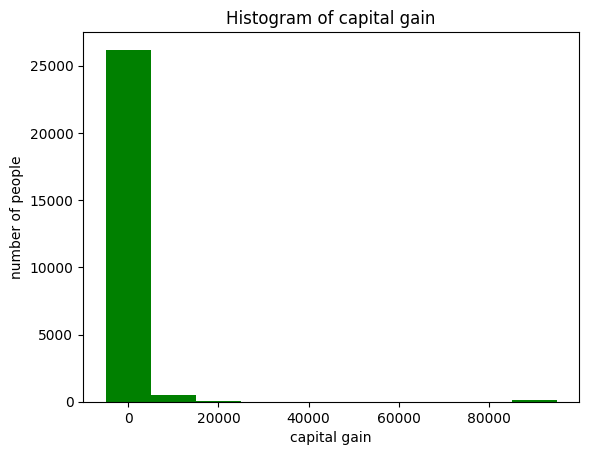

In [282]:
print("capital gain:\n:",df["capital_gain"].describe())
plt.hist(df["capital_gain"],color="g",align ='left')
plt.title('Histogram of capital gain')
plt.xlabel('capital gain')
plt.ylabel('number of people')
plt.show()


Histogram of capital loss

capital loss:
: count    26911.000000
mean        98.480175
std        425.626685
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital_loss, dtype: float64


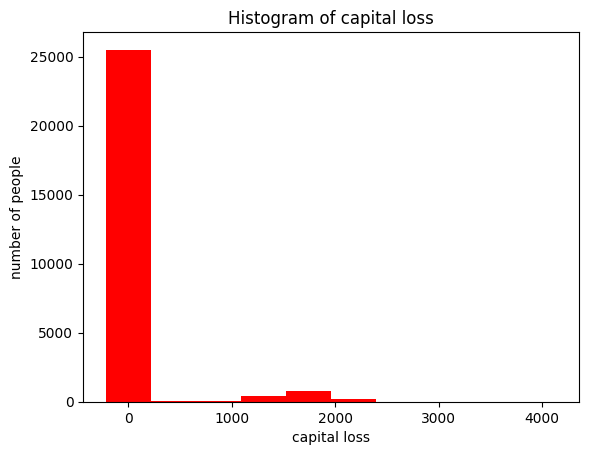

In [283]:
print("capital loss:\n:",df["capital_loss"].describe())
plt.hist(df["capital_loss"],color="r",align ='left')
plt.title('Histogram of capital loss')
plt.xlabel('capital loss')
plt.ylabel('number of people')
plt.show()

Histogram of age

age:
: count    26911.000000
mean        39.044071
std         13.190480
min         17.000000
25%         29.000000
50%         38.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64


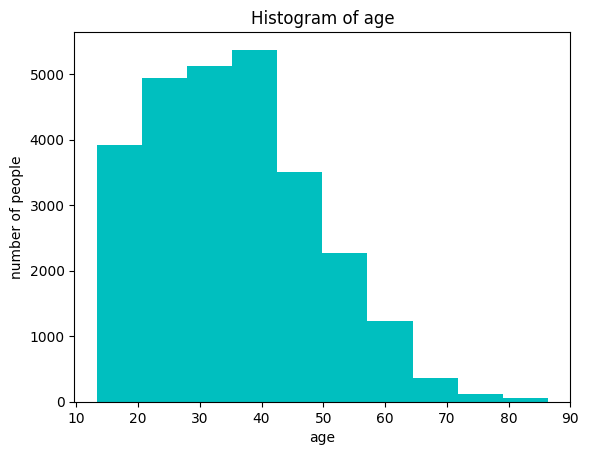

In [284]:
print("age:\n:",df["age"].describe())
plt.hist(df["age"],color="c",align="left")
plt.title('Histogram of age')
plt.xlabel('age')
plt.ylabel('number of people')
plt.show()

Histogram of hours per week

hours per week:
: count    26911.000000
mean        41.153840
std         12.363053
min          0.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours_per_week, dtype: float64


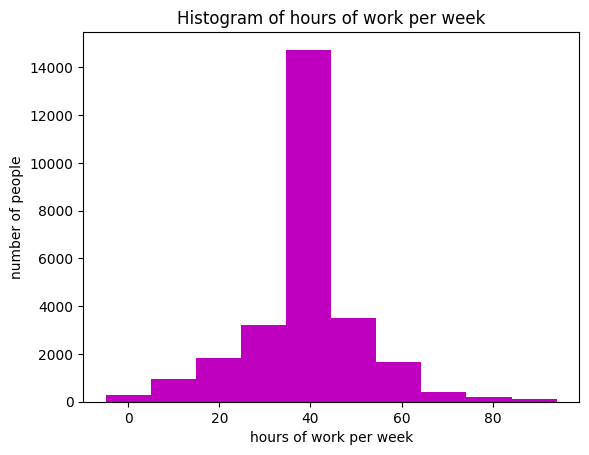

In [285]:
print("hours per week:\n:",df["hours_per_week"].describe())
plt.hist(df["hours_per_week"],color="m",align="left")
plt.title('Histogram of hours of work per week')
plt.xlabel('hours of work per week')
plt.ylabel('number of people')
plt.show()

Histogram of education

education:
: count    26911.000000
mean        10.143584
std          2.620356
min          1.000000
25%          9.000000
50%         10.000000
75%         13.000000
max         16.000000
Name: education, dtype: float64


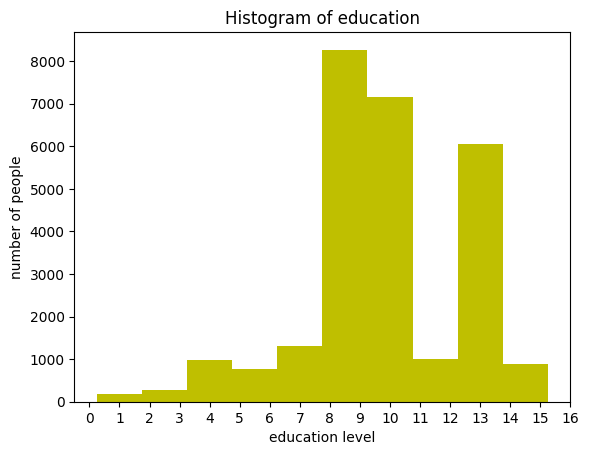

In [286]:
print("education:\n:",df["education"].describe())
plt.hist(df["education"],color="y",align ='left')
plt.title('Histogram of education')
plt.xlabel('education level')
plt.ylabel('number of people')
plt.xticks([x for x in range(17)])
plt.show()

Histogram of above or below 50k

above or below 50k:
: count     26911
unique        2
top       <=50K
freq      20031
Name: above_or_below_50k, dtype: object

Number of each value in the column:
<=50K    20031
>50K      6880
Name: above_or_below_50k, dtype: int64



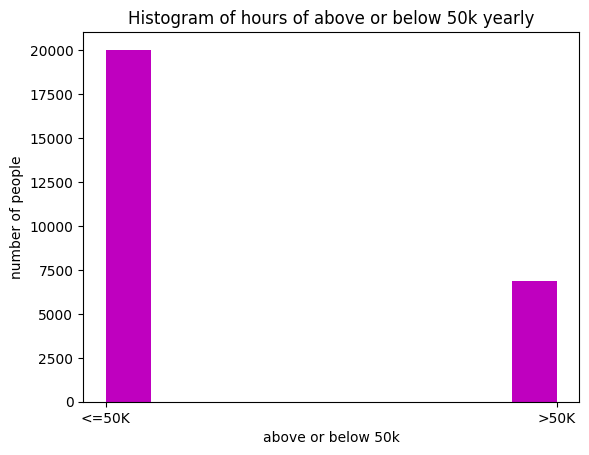

In [287]:
print("above or below 50k:\n:",df["above_or_below_50k"].describe())
print("\nNumber of each value in the column:\n",df["above_or_below_50k"].value_counts(),"\n",sep="")
plt.hist(df["above_or_below_50k"],color="m")
plt.title('Histogram of hours of above or below 50k yearly')
plt.xlabel('above or below 50k')
plt.ylabel('number of people')
plt.xticks([0,1])
plt.show()

Converting Categorical to Numerical

In [288]:
#This part of pre processing is executed now as it is needed for scatter matrix
#a dictionary that will store the categorical to numerical conversion:
CategoricalToNumericalDicts = {}
#add the existing education conversion to the dictionary:
CategoricalToNumericalDicts["education"] = education_dict
#for each cateogrical column:
for column in cat_cols: 
    #fill one list with unique values in the column:
    old_values = df[column].unique()
    #fill second list with range of numbers corresponding to these unique values:
    new_values = [x for x in range(len(old_values))]
    #create a dictionary with unique values and corresponding numbers:
    dictionary = dict(zip(old_values, new_values))
    #add this dictionary to the main dictionary as a value, with key being column name:
    CategoricalToNumericalDicts[column] = dictionary
    #replace categorical values with numerical equivalents:
    df[column].replace(old_values,new_values,inplace=True)
CategoricalToNumericalDicts["native_country"]

{'United-States': 0,
 'Cuba': 1,
 'Jamaica': 2,
 'India': 3,
 'Mexico': 4,
 'Puerto-Rico': 5,
 'Honduras': 6,
 'England': 7,
 'Canada': 8,
 'Germany': 9,
 'Iran': 10,
 'Philippines': 11,
 'Poland': 12,
 'Columbia': 13,
 'Cambodia': 14,
 'Thailand': 15,
 'Ecuador': 16,
 'Laos': 17,
 'Taiwan': 18,
 'Haiti': 19,
 'Portugal': 20,
 'Dominican-Republic': 21,
 'El-Salvador': 22,
 'France': 23,
 'Guatemala': 24,
 'Italy': 25,
 'China': 26,
 'South': 27,
 'Japan': 28,
 'Yugoslavia': 29,
 'Peru': 30,
 'Outlying-US(Guam-USVI-etc)': 31,
 'Scotland': 32,
 'Trinadad&Tobago': 33,
 'Greece': 34,
 'Nicaragua': 35,
 'Vietnam': 36,
 'Hong': 37,
 'Ireland': 38,
 'Hungary': 39,
 'Holand-Netherlands': 40}

Scatter Matrix

array([[<AxesSubplot:xlabel='capital_loss', ylabel='capital_loss'>,
        <AxesSubplot:xlabel='capital_gain', ylabel='capital_loss'>,
        <AxesSubplot:xlabel='age', ylabel='capital_loss'>,
        <AxesSubplot:xlabel='hours_per_week', ylabel='capital_loss'>,
        <AxesSubplot:xlabel='education', ylabel='capital_loss'>,
        <AxesSubplot:xlabel='above_or_below_50k', ylabel='capital_loss'>],
       [<AxesSubplot:xlabel='capital_loss', ylabel='capital_gain'>,
        <AxesSubplot:xlabel='capital_gain', ylabel='capital_gain'>,
        <AxesSubplot:xlabel='age', ylabel='capital_gain'>,
        <AxesSubplot:xlabel='hours_per_week', ylabel='capital_gain'>,
        <AxesSubplot:xlabel='education', ylabel='capital_gain'>,
        <AxesSubplot:xlabel='above_or_below_50k', ylabel='capital_gain'>],
       [<AxesSubplot:xlabel='capital_loss', ylabel='age'>,
        <AxesSubplot:xlabel='capital_gain', ylabel='age'>,
        <AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:x

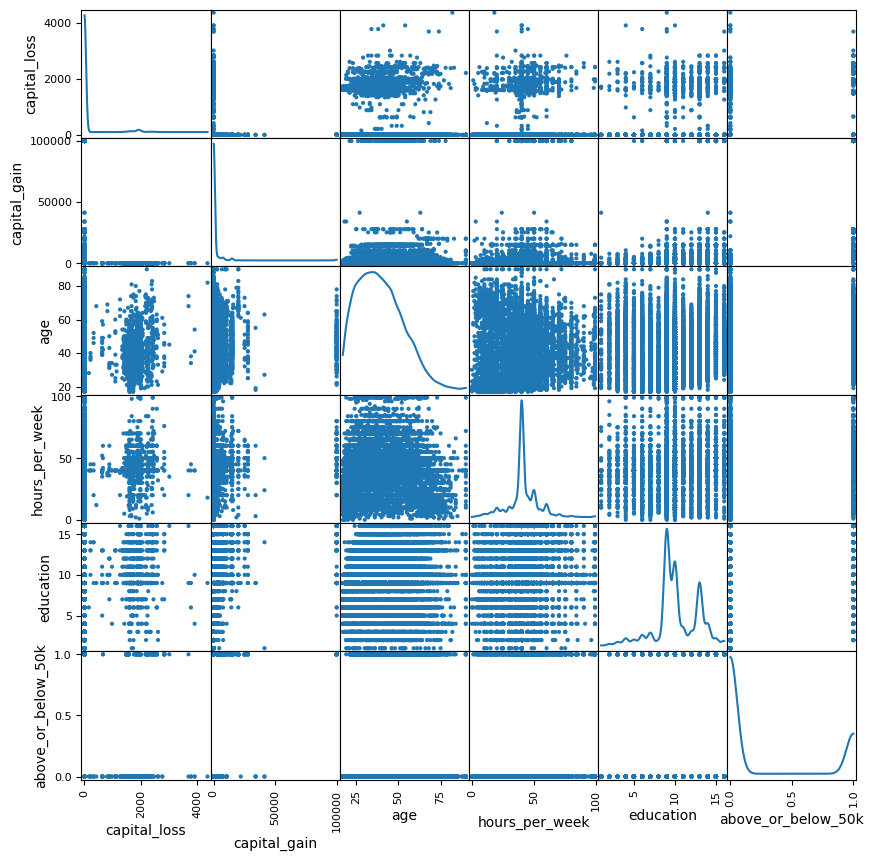

In [289]:
scatter_matrix(df[["capital_loss","capital_gain","age","hours_per_week","education","above_or_below_50k"]],diagonal = 'kde',alpha = 1,figsize = (10, 10))

Education and above_or_below_50k stacked bar chart

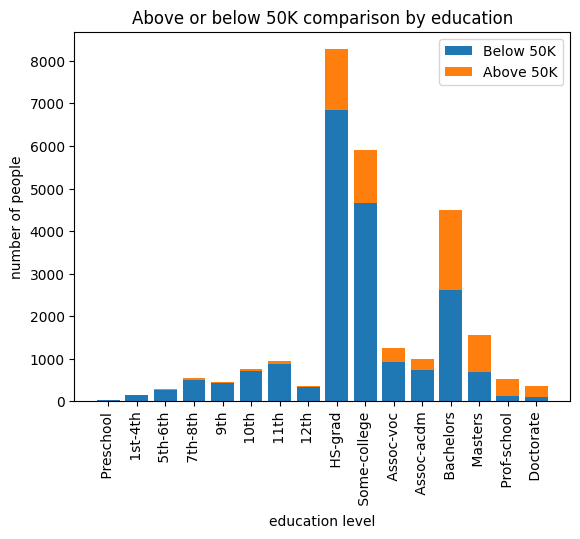

In [290]:
#group the dataframe by education:
group = df.groupby('education')
#create a Series consisting of each value of education, and its corresponding
#ammount of 0 and 1 values("0" being below 50k and "1" being above 50K)
df2 = group.apply(lambda x: x['above_or_below_50k'].value_counts())
#convert Series to dictionary:
df2_dict = df2.to_dict()

#list of ammount of people with each education earning less than 50k: 
below_50 = []
#list of ammount of people with each education earning more than 50k:
above_50 = []

#list of number range from 1 to 16, labels for bars:
labels = [x for x in range(1,17)]
#for every education value:
for i in range(1,17):
    #for every above_or_below 50k value:
    for j in [0,1]:
        try:
            #if the corresponding value exist in df2_dict
            # set is as a new entry
            new_entry = df2_dict[(i,j)]
        except:
            #if not, it means that the educatinal level has zero examples
            # of people either above or below 50k, so the new entry is also 0:
            new_entry = 0
        finally:
            if j == 0:
                #assign the new entry to below 50k list:
                below_50.append(new_entry)
            else:
                #assign the new entry to above 50k list:
                above_50.append(new_entry)

fig, ax = plt.subplots()
#first bar in a stacked bar chart, people earning below 50k:
ax.bar(labels, below_50,label='Below 50K')
#first bar in a stacked bar chart, people earning above 50k:
ax.bar(labels, above_50, bottom=below_50,label='Above 50K')

plt.xlabel("education level")
plt.ylabel("number of people")
plt.title('Above or below 50K comparison by education')
plt.legend()
#set the x ticks to be values of keys in education dictionary:
plt.xticks(labels,[x for x in education_dict.keys()],rotation="vertical")
plt.show()

Create training and testing data

In [291]:
#X is every column except above_or_below_50k
X = df.loc[:, df.columns != 'above_or_below_50k']
y = df['above_or_below_50k']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Scaling features

In [292]:
#MinMax scaling
minMaxScaleX_train = MinMaxScaler().fit_transform(X_train)
minMaxScaleX_test = MinMaxScaler().fit_transform(X_test)

#Standard scaling
standardScaleX_train = StandardScaler().fit_transform(X_train)
standardScaleX_test = StandardScaler().fit_transform(X_test)

#Robust scaling
robustScaleX_train = RobustScaler().fit_transform(X_train)
robustScaleX_test = RobustScaler().fit_transform(X_test)

#dictionaries with scaled data
scaledTrainX = {"minMax":minMaxScaleX_train,"standard":standardScaleX_train,"robust":robustScaleX_train}
scaledTestX = {"minMax":minMaxScaleX_test,"standard":standardScaleX_test,"robust":robustScaleX_test}


Function preforming Random Search on different scaling

In [293]:
def scaleTest(MLmodel,MLparams):
    """
    Input: a machine learning model, hyperparameters for said model
    Output: model with best hyperparameters, best scaling for the model
    The function carries out a random search 50 times on three different scales,
    with cross validation, and chooses the one where the scaling and hyperparameters
    gave the best score
    """
    bestScaling = 0
    bestScore = 0
    search = RandomizedSearchCV(MLmodel, MLparams,n_iter=50,cv=5,n_jobs=-1)
    #for each key and value in scaled data dictionary:
    for scaleName,scaledX in scaledTrainX.items():
        #preform random search with cross-validation on scaled data:
        searchModel = search.fit(scaledX,y_train)
        #if the random search gave better result than the current best:
        if searchModel.best_score_ > bestScore:
            bestScaling = scaleName
            bestModel = searchModel.best_estimator_
    return bestModel, bestScaling

Logistic regression

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4006
           1       0.71      0.47      0.56      1377

    accuracy                           0.82      5383
   macro avg       0.77      0.70      0.72      5383
weighted avg       0.80      0.82      0.80      5383

best scaling:  robust
cross validated accuracy:  0.8176790292884683
cross validated recall:  0.4570248534390224
cross validated precision:  0.7289336973823308


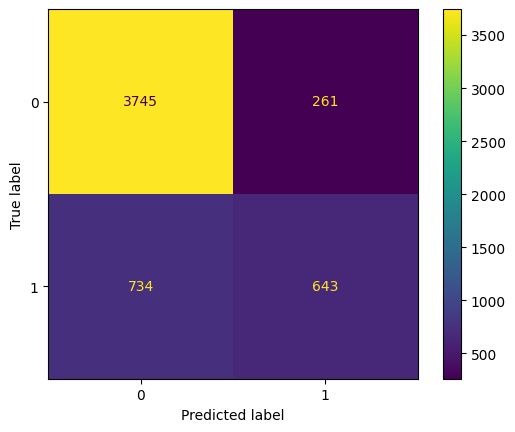

In [294]:
logReg = LogisticRegression()
logRegParams = {"C":[0.1,0.5,1,10,100],"intercept_scaling":[0.1,0.5,1,10,100],"solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}
#preform random search:
search_result = scaleTest(logReg,logRegParams)
#trained model:
logReg = search_result[0]
#best scaling for the model:
scaling = search_result[1]

#test the model on test data:
logRegPredict = logReg.predict(scaledTestX[scaling])
class_rep = classification_report(y_test,logRegPredict)

print(class_rep)
print("best scaling: ",scaling)

#preform cross validation on training data:
cross_val = cross_validate(logReg,scaledTrainX[scaling],y_train,scoring=("accuracy","recall","precision"),cv=5,n_jobs=-1)
print("cross validated accuracy: ",np.mean(cross_val["test_accuracy"]))
print("cross validated recall: ",np.mean(cross_val["test_recall"]))
print("cross validated precision: ",np.mean(cross_val["test_precision"]))

#produce a confusion matrix:
conf_matrix = confusion_matrix(y_test,logRegPredict)
ConfusionMatrixDisplay(conf_matrix).plot()

MLP

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4006
           1       0.68      0.59      0.63      1377

    accuracy                           0.82      5383
   macro avg       0.77      0.75      0.76      5383
weighted avg       0.82      0.82      0.82      5383

best scaling:  robust
cross validated accuracy:  0.8239038200215457
cross validated recall:  0.5638743291222855
cross validated precision:  0.6971153246360776


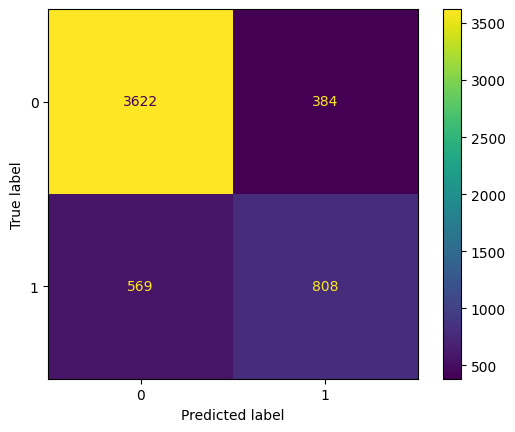

In [295]:
mlp = MLPClassifier()
mlpParams = {"hidden_layer_sizes":[1,2,3,5,10,50,100],"activation":["identity", "logistic", "tanh", "relu"],"solver":["sgd", "adam"],"alpha":[0.0001,0.001,0.01,0.1,1],"learning_rate_init":[0.001,0.01,0.1,1]}
#preform random search:
search_result = scaleTest(mlp,mlpParams)
#trained model:
mlp = search_result[0]
#best scaling for the model:
scaling = search_result[1]

#test the model on test data:
mlpPredict = mlp.predict(scaledTestX[scaling])
class_rep = classification_report(y_test,mlpPredict)

print(class_rep)
print("best scaling: ",scaling)

#preform cross validation on training data:
cross_val = cross_validate(mlp,scaledTrainX[scaling],y_train,scoring=("accuracy","recall","precision"),cv=5,n_jobs=-1)
print("cross validated accuracy: ",np.mean(cross_val["test_accuracy"]))
print("cross validated recall: ",np.mean(cross_val["test_recall"]))
print("cross validated precision: ",np.mean(cross_val["test_precision"]))

#produce a confusion matrix:
conf_matrix = confusion_matrix(y_test,mlpPredict)
ConfusionMatrixDisplay(conf_matrix).plot()

K Neighbour

              precision    recall  f1-score   support

           0       0.88      0.94      0.90      4006
           1       0.77      0.61      0.68      1377

    accuracy                           0.85      5383
   macro avg       0.82      0.77      0.79      5383
weighted avg       0.85      0.85      0.85      5383

best scaling:  robust
cross validated accuracy:  0.8508919245651881
cross validated recall:  0.5994902155065642
cross validated precision:  0.7664950333394324


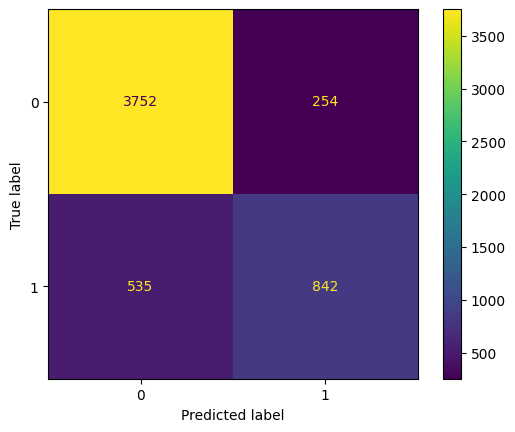

In [296]:
kNeig = KNeighborsClassifier()
kNeigParams = {"n_neighbors":[4,5,6,7,10,20,30],"weights":["uniform", "distance"],"algorithm":["auto", "ball_tree", "kd_tree", "brute"],"p":[1,2,3,4,5,10,100]}
#preform random search:
search_result = scaleTest(kNeig,kNeigParams)
#trained model:
kNeig = search_result[0]
#best scaling for the model:
scaling = search_result[1]

#test the model on test data:
kNeigPredict = kNeig.predict(scaledTestX[scaling])
class_rep = classification_report(y_test,kNeigPredict)

print(class_rep)
print("best scaling: ",scaling)

#preform cross validation on training data:
cross_val = cross_validate(kNeig,scaledTrainX[scaling],y_train,scoring=("accuracy","recall","precision"),cv=5,n_jobs=-1)
print("cross validated accuracy: ",np.mean(cross_val["test_accuracy"]))
print("cross validated recall: ",np.mean(cross_val["test_recall"]))
print("cross validated precision: ",np.mean(cross_val["test_precision"]))

#produce a confusion matrix:
conf_matrix = confusion_matrix(y_test,kNeigPredict)
ConfusionMatrixDisplay(conf_matrix).plot()

Decision Tree

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      4006
           1       0.72      0.62      0.66      1377

    accuracy                           0.84      5383
   macro avg       0.80      0.77      0.78      5383
weighted avg       0.83      0.84      0.84      5383

best scaling:  robust
cross validated accuracy:  0.834773206281595
cross validated recall:  0.5913164891421022
cross validated precision:  0.7142926927081713


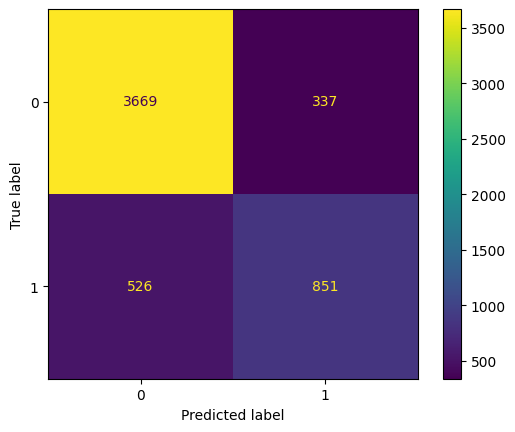

In [297]:
decTree = DecisionTreeClassifier()
decTreeParams = {"criterion":["gini", "entropy", "log_loss"],"splitter":["best", "random"],"min_samples_split":[1,2,3,4,5],"min_samples_leaf":[1,2,3,4,5],"max_features":["sqrt", "log2"],"min_weight_fraction_leaf":[0.0,0.1,0.2,0.5,1.0]}
#preform random search:
search_result = scaleTest(decTree,decTreeParams)
#trained model:
decTree = search_result[0]
#best scaling for the model:
scaling = search_result[1]

#test the model on test data:
decTreePredict = decTree.predict(scaledTestX[scaling])
class_rep = classification_report(y_test,decTreePredict)

print(class_rep)
print("best scaling: ",scaling)

#preform cross validation on training data:
cross_val = cross_validate(decTree,scaledTrainX[scaling],y_train,scoring=("accuracy","recall","precision"),cv=5,n_jobs=-1)
print("cross validated accuracy: ",np.mean(cross_val["test_accuracy"]))
print("cross validated recall: ",np.mean(cross_val["test_recall"]))
print("cross validated precision: ",np.mean(cross_val["test_precision"]))

#produce a confusion matrix:
conf_matrix = confusion_matrix(y_test,decTreePredict)
ConfusionMatrixDisplay(conf_matrix).plot()

Random Forest

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4006
           1       0.78      0.64      0.70      1377

    accuracy                           0.86      5383
   macro avg       0.83      0.79      0.81      5383
weighted avg       0.86      0.86      0.86      5383

best scaling:  robust
cross validated accuracy:  0.8531212531686062
cross validated recall:  0.6073019568986872
cross validated precision:  0.7695131345016295


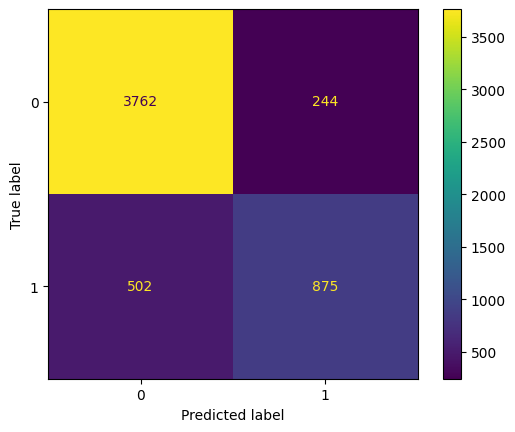

In [298]:
randFor = RandomForestClassifier()
randForParams = {"n_estimators":[10,50,100,200,500],"criterion":["gini", "entropy", "log_loss"],"min_samples_split":[1,2,3,4,5],"min_samples_leaf":[1,2,3,4,5],"max_features":["sqrt", "log2", None],"min_weight_fraction_leaf":[0.0,0.1,0.2,0.5,1.0]}
#preform random search:
search_result = scaleTest(randFor,randForParams)
#trained model:
randFor = search_result[0]
#best scaling for the model:
scaling = search_result[1]

#test the model on test data:
randForPredict = randFor.predict(scaledTestX[scaling])
class_rep = classification_report(y_test,randForPredict)

print(class_rep)
print("best scaling: ",scaling)

#preform cross validation on training data:
cross_val = cross_validate(randFor,scaledTrainX[scaling],y_train,scoring=("accuracy","recall","precision"),cv=5,n_jobs=-1)
print("cross validated accuracy: ",np.mean(cross_val["test_accuracy"]))
print("cross validated recall: ",np.mean(cross_val["test_recall"]))
print("cross validated precision: ",np.mean(cross_val["test_precision"]))

#produce a confusion matrix:
conf_matrix = confusion_matrix(y_test,randForPredict)
ConfusionMatrixDisplay(conf_matrix).plot()

SVC

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4006
           1       0.80      0.58      0.67      1377

    accuracy                           0.86      5383
   macro avg       0.84      0.76      0.79      5383
weighted avg       0.85      0.86      0.85      5383

best scaling:  robust
cross validated accuracy:  0.8533538972441015
cross validated recall:  0.5667827594748576
cross validated precision:  0.8017288167933275


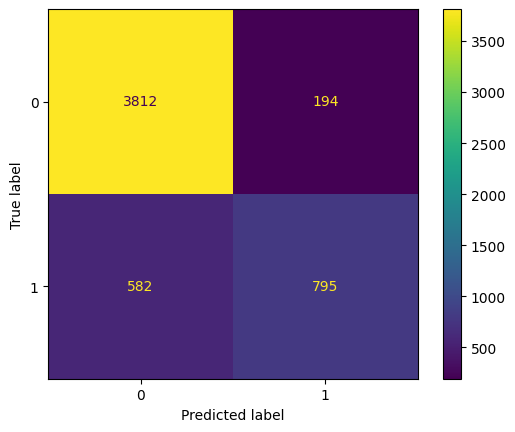

In [299]:
svc = SVC()
svcParams = {"C":[0.1,0.5,1,10,100],"gamma":["scale", "auto"],"coef0":[0.0,0.1,0.5,1.0],"shrinking":[True,False]}
#preform random search:
search_result = scaleTest(svc,svcParams)
#trained model:
svc = search_result[0]
#best scaling for the model:
scaling = search_result[1]

#test the model on test data:
svcPredict = svc.predict(scaledTestX[scaling])
class_rep = classification_report(y_test,svcPredict)

print(class_rep)
print("best scaling: ",scaling)

#preform cross validation on training data:
cross_val = cross_validate(svc,scaledTrainX[scaling],y_train,scoring=("accuracy","recall","precision"),cv=5,n_jobs=-1)
print("cross validated accuracy: ",np.mean(cross_val["test_accuracy"]))
print("cross validated recall: ",np.mean(cross_val["test_recall"]))
print("cross validated precision: ",np.mean(cross_val["test_precision"]))

#produce a confusion matrix:
conf_matrix = confusion_matrix(y_test,svcPredict)
ConfusionMatrixDisplay(conf_matrix).plot()

Gaussian Naive Bayes

              precision    recall  f1-score   support

           0       0.82      0.94      0.87      4006
           1       0.68      0.39      0.50      1377

    accuracy                           0.80      5383
   macro avg       0.75      0.67      0.69      5383
weighted avg       0.78      0.80      0.78      5383

best scaling:  robust
cross validated accuracy:  0.7942216705426295
cross validated recall:  0.37089043018743295
cross validated precision:  0.6780934910056646


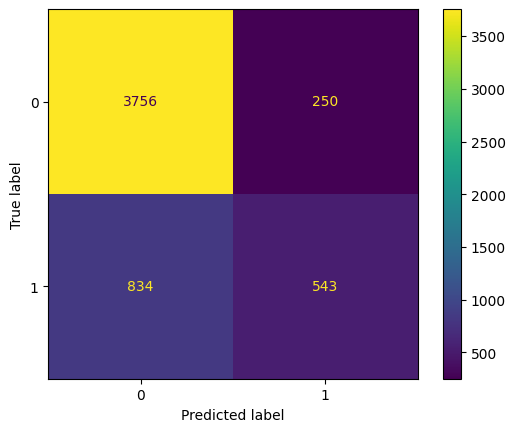

In [300]:
GaussNB = GaussianNB()
GaussNBParams = {"var_smoothing":[1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1]}
#preform random search:
search_result = scaleTest(GaussNB,GaussNBParams)
#trained model:
GaussNB = search_result[0]
#best scaling for the model:
scaling = search_result[1]

#test the model on test data:
GaussNBPredict = GaussNB.predict(scaledTestX[scaling])
class_rep = classification_report(y_test,GaussNBPredict)

print(class_rep)
print("best scaling: ",scaling)

#preform cross validation on training data:
cross_val = cross_validate(GaussNB,scaledTrainX[scaling],y_train,scoring=("accuracy","recall","precision"),cv=5,n_jobs=-1)
print("cross validated accuracy: ",np.mean(cross_val["test_accuracy"]))
print("cross validated recall: ",np.mean(cross_val["test_recall"]))
print("cross validated precision: ",np.mean(cross_val["test_precision"]))

#produce a confusion matrix:
conf_matrix = confusion_matrix(y_test,GaussNBPredict)
ConfusionMatrixDisplay(conf_matrix).plot()